In [1]:
from copy import copy
import seaborn as sns
import pandas as pd
import math

In [2]:
def take_samples(a, b, n):
    assert a < b and n > 1

    def f(x):
        return x**3 - 3*x**2 - 17*x + 22 + math.sin(x)

    h = (b - a) / (n-1)
    table = []
    for i in range(n):
        xi = a + i*h
        table.append((xi, f(xi)))

    return table

<AxesSubplot: >

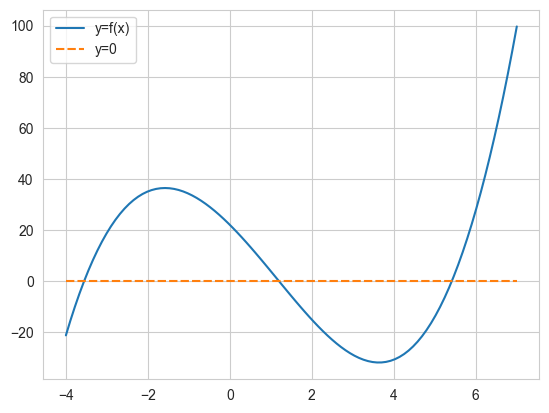

In [3]:
rendering_samples = take_samples(-4, 7, 101)
rendering_dataframe = pd.DataFrame(((b, 0) for a, b in rendering_samples), index=[a for a,b in rendering_samples], columns=['y=f(x)', 'y=0'])
sns.lineplot(rendering_dataframe)

In [4]:
a = 4
b = 5.8
h = .2

In [5]:
samples = take_samples(a, b, 10)
pd.DataFrame(samples, columns=['xi', 'f(xi)'])

,xi,f(xi)
0,4.0,-30.756802
1,4.2,-29.103576
2,4.4,-26.647602
3,4.6,-23.337691
4,4.8,-19.124165
5,5.0,-13.958924
6,5.2,-7.795455
7,5.4,-0.588764
8,5.6,7.704733
9,5.8,17.127398


In [6]:
def get_ms(h, f, util=False):
    Hf = [(f[i-1] - 2*f[i] + f[i+1])/h for i in range(1, len(f)-1)]

    # three-diagonal method
    a = h/6
    b = h/6
    c = -2*h/3

    # forward pass
    alphas = [b/c]
    betas = [-Hf[0]/c]
    zs = [c]
    for i in range(len(Hf)-2):
        alpha_new = b / zs[i]
        beta_new = (-Hf[i] + a*betas[i]) / zs[i]
        z_new = c - alphas[i]*a

        alphas.append(alpha_new)
        betas.append(beta_new)
        zs.append(z_new)

    # backward pass
    ms = [(-Hf[-1] + a*betas[-1])/zs[-1]]
    for i in range(len(Hf)-2, -1, -1):
        ms = [alphas[i]*ms[0] + betas[i]] + ms


    return [0] + ms + [0]


In [7]:
ms = get_ms(h, [f for x, f in samples], True)

In [8]:
for i, m in enumerate(ms):
    print(f'm{i} = {m:.4f}')

m0 = 0.0000
m1 = 25.8453
m2 = 17.0309
m3 = 22.1853
m4 = 22.3186
m5 = 23.7108
m6 = 25.5953
m7 = 23.6120
m8 = 36.4400
m9 = 0.0000


In [9]:
class S:    # cubic spline for one interval
    def __init__(self, x0, x1, y0, y1, m0, m1, h):
        self.c1 = m0 / (6*h)
        self.c2 = m1 / (6*h)
        self.c3 = y0/h - m0*h/6
        self.c4 = y1/h - m1*h/6
        self.x0 = x0
        self.x1 = x1

    def __call__(self, x):
        return self.c1 * (self.x1 - x)**3 + self.c2 * (x - self.x0)**3 + self.c3 * (self.x1 - x) + self.c4 * (x - self.x0)

    def __str__(self):
        addant1 = f'{self.c1:.4f} * ({self.x1:.4f} - x)^3'
        addant2 = f'{self.c2:.4f} * (x - {self.x0:.4f})^3'
        addant3 = f'{self.c1:.4f} * ({self.x1:.4f} - x)'
        addant4 = f'{self.c2:.4f} * (x - {self.x0:.4f})'
        return f'{addant1} + {addant2} + {addant3} + {addant4}'

In [10]:
class Spline:   # cubic spline for many intervals
    def __init__(self, xs, ys, ms, h):
        self._splines = []
        for i in range(len(xs)-1):
            self._splines.append(S(xs[i], xs[i+1], ys[i], ys[i+1], ms[i], ms[i+1], h))

    def __call__(self, x):
        for s in self._splines:
            if x <= s.x1:
                return s(x)
        return self._splines[-1](x)

    def __str__(self):
        res = ''
        for s in self._splines:
            res += f'[{s.x0:7.4f}, {s.x1:7.4f}] : {s}\n'
        return res


In [11]:
spline = Spline([x for x, y in samples], [y for x, y in samples], ms, h)

In [12]:
print(spline)

[ 4.0000,  4.2000] : 0.0000 * (4.2000 - x)^3 + 21.5377 * (x - 4.0000)^3 + 0.0000 * (4.2000 - x) + 21.5377 * (x - 4.0000)
[ 4.2000,  4.4000] : 21.5377 * (4.4000 - x)^3 + 14.1924 * (x - 4.2000)^3 + 21.5377 * (4.4000 - x) + 14.1924 * (x - 4.2000)
[ 4.4000,  4.6000] : 14.1924 * (4.6000 - x)^3 + 18.4877 * (x - 4.4000)^3 + 14.1924 * (4.6000 - x) + 18.4877 * (x - 4.4000)
[ 4.6000,  4.8000] : 18.4877 * (4.8000 - x)^3 + 18.5988 * (x - 4.6000)^3 + 18.4877 * (4.8000 - x) + 18.5988 * (x - 4.6000)
[ 4.8000,  5.0000] : 18.5988 * (5.0000 - x)^3 + 19.7590 * (x - 4.8000)^3 + 18.5988 * (5.0000 - x) + 19.7590 * (x - 4.8000)
[ 5.0000,  5.2000] : 19.7590 * (5.2000 - x)^3 + 21.3294 * (x - 5.0000)^3 + 19.7590 * (5.2000 - x) + 21.3294 * (x - 5.0000)
[ 5.2000,  5.4000] : 21.3294 * (5.4000 - x)^3 + 19.6766 * (x - 5.2000)^3 + 21.3294 * (5.4000 - x) + 19.6766 * (x - 5.2000)
[ 5.4000,  5.6000] : 19.6766 * (5.6000 - x)^3 + 30.3667 * (x - 5.4000)^3 + 19.6766 * (5.6000 - x) + 30.3667 * (x - 5.4000)
[ 5.6000,  5.8000]

<AxesSubplot: >

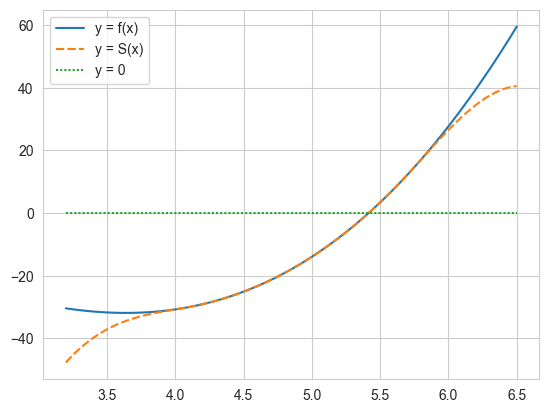

In [13]:
rendering_samples = take_samples(3.2, 6.5, 101)
rendering_dataframe = pd.DataFrame(((b, spline(a), 0) for a, b in rendering_samples), index=[a for a,b in rendering_samples], columns=['y = f(x)', 'y = S(x)', 'y = 0'])

sns.lineplot(rendering_dataframe)

## Comparison with Newton's interpolation function

In [14]:
def get_finite_differences(samples):
    table = [[y for x, y in samples]]

    for o in range(len(table[0]) - 1):
        new_fd = []
        for i in range(len(table[-1]) - 1):
            new_fd.append(table[-1][i + 1] - table[-1][i])
        table.append(new_fd)

    return [df[0] for df in table[1:]]


In [15]:
fds = get_finite_differences(samples)
# ignore negligible finite differences
fds = fds[:6]

In [16]:
def get_p_by_fd(fds, x0, y0, h):
    fds = copy(fds)

    def p(x):
        t = (x - x0) / h

        res = y0
        t_product = 1
        factorial = 1

        for i, fd in enumerate(fds):
            t_product *= t - i
            factorial *= i + 1

            res += fd * t_product / factorial

        return res

    return p

In [17]:
polynomial = get_p_by_fd(fds, x0=samples[0][0], y0=samples[0][1], h=.2)

<AxesSubplot: >

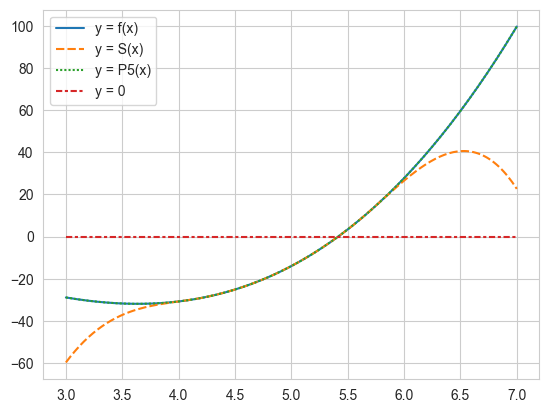

In [18]:
rendering_samples = take_samples(3, 7, 200)
rendering_dataframe = pd.DataFrame(((b, spline(a), polynomial(a), 0) for a, b in rendering_samples), index=[a for a,b in rendering_samples], columns=['y = f(x)', 'y = S(x)', 'y = P5(x)', 'y = 0'])
sns.lineplot(rendering_dataframe)